In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
%watermark

Last updated: 2024-07-19T15:40:19.997621-04:00

Python implementation: CPython
Python version       : 3.12.2
IPython version      : 8.22.2

Compiler    : MSC v.1937 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 167 Stepping 1, GenuineIntel
CPU cores   : 16
Architecture: 64bit



In [2]:
# Libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm

import os

from func_utils import *

# Basket
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth

# Network graph
import networkx as nx

# Display and graph options

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# Customize the font and title size
custom_params = {
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "font.family": "Arial"
}
sns.set_context("notebook", rc=custom_params)

# Set a color palette
sns.set_palette("Set2") 

# Set global option to display numbers in plain format
pd.set_option('display.float_format', '{:.2f}'.format)

# Filter warnings and seeds
import warnings
import random

warnings.filterwarnings('ignore')
random.seed(1234)

In [3]:
# Data 

data_tmp = pd.read_csv('DATA/base_main.csv')

In [4]:
data_tmp.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,...,Transaction_Date2,Month,Coupon_Code,Discount_pct,Discount_pct_ajus,Invoice,Gender,Location,Tenure_Months,month
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,...,2019-01-01,Jan,ELEC10,10.00,10.00,194.37,M,Chicago,12,1
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,...,2019-01-01,Jan,ELEC10,10.00,10.00,194.37,M,Chicago,12,1
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.50,Used,...,2019-01-01,Jan,OFF10,10.00,10.00,9.01,M,Chicago,12,1
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.50,Not Used,...,2019-01-01,Jan,SALE10,10.00,0.00,109.93,M,Chicago,12,1
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.50,Used,...,2019-01-01,Jan,AIO10,10.00,10.00,28.13,M,Chicago,12,1


## 5. Cross-Selling (Which products are selling together)  
You can perform exploratory analysis & market basket analysis to understand which of items can be bundled together.

Ref.: [https://365datascience.com/tutorials/python-tutorials/market-basket-analysis/]

In [31]:
basket = (
    data_tmp.groupby(['Transaction_ID', 'Product_Description'])['Product_Description']
    .count().unstack().reset_index().fillna(0)
    .set_index('Transaction_ID')
)

# Convert values to 1 and 0
basket = basket.applymap(lambda x: 1 if x > 0 else 0)


In [46]:
basket.head()

Product_Description,1 oz Hand Sanitizer,20 oz Stainless Steel Insulated Tumbler,22 oz Android Bottle,22 oz YouTube Bottle Infuser,23 oz Wide Mouth Sport Bottle,24 oz YouTube Sergeant Stripe Bottle,25L Classic Rucksack,26 oz Double Wall Insulated Bottle,7&quot; Dog Frisbee,8 pc Android Sticker Sheet,...,YouTube Twill Cap,YouTube Women's Favorite Tee White,YouTube Women's Fleece Hoodie Black,YouTube Women's Racer Back Tank Black,YouTube Women's Short Sleeve Hero Tee Charcoal,YouTube Women's Short Sleeve Tri-blend Badge Tee Charcoal,YouTube Women's Short Sleeve Tri-blend Badge Tee Grey,YouTube Womens 3/4 Sleeve Baseball Raglan White/Black,YouTube Wool Heather Cap Heather/Black,YouTube Youth Short Sleeve Tee Red
Transaction_ID,,,,,,,,,,,,,,,,,,,,,
16679,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16680,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16681,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16682,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16684,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- Support: we use it to assess the overall popularity of a given product with the following formula: Support(item) = Transactions comprising the item / Total transactions. High support correlates to a frequent itemset.
- Confidence: Likelihood of different purchase combinations. We calculate that using the following formula: Confidence (Bread -> Milk) = Transactions comprising P_A and P_B / Transactions comprising P_A. High confidence indicates a strong rule.
- Lift:  refers to the increase in the ratio of the sale of Product_A when you sell Product_B. Values > 1 indicate that the rules are useful.

In [33]:
# Generate frequent itemsets
frequent_itemsets = apriori(basket, min_support=0.001, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift")

# Display the results
rules.head()


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(1 oz Hand Sanitizer),(Google 22 oz Water Bottle),0.01,0.03,0.00,0.29,10.51,0.00,1.36,0.91
1,(Google 22 oz Water Bottle),(1 oz Hand Sanitizer),0.03,0.01,0.00,0.05,10.51,0.00,1.05,0.93
2,(1 oz Hand Sanitizer),(Google Kick Ball),0.01,0.01,0.00,0.22,20.05,0.00,1.28,0.96
3,(Google Kick Ball),(1 oz Hand Sanitizer),0.01,0.01,0.00,0.10,20.05,0.00,1.11,0.96
4,(1 oz Hand Sanitizer),(Google Laptop and Cell Phone Stickers),0.01,0.03,0.00,0.20,6.27,0.00,1.21,0.84


In [34]:
rules.sort_values(["support", "confidence","lift"],axis = 0, ascending = False).head(8)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
401,(Nest Cam Indoor Security Camera - USA),(Nest Cam Outdoor Security Camera - USA),0.13,0.13,0.03,0.21,1.62,0.01,1.10,0.44
400,(Nest Cam Outdoor Security Camera - USA),(Nest Cam Indoor Security Camera - USA),0.13,0.13,0.03,0.21,1.62,0.01,1.10,0.44
414,(Nest Protect Smoke + CO White Battery Alarm-USA),(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.05,0.14,0.01,0.17,1.19,0.00,1.03,0.17
415,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,(Nest Protect Smoke + CO White Battery Alarm-USA),0.14,0.05,0.01,0.06,1.19,0.00,1.01,0.18
404,(Nest Protect Smoke + CO White Battery Alarm-USA),(Nest Cam Outdoor Security Camera - USA),0.05,0.13,0.01,0.14,1.06,0.00,1.01,0.06
405,(Nest Cam Outdoor Security Camera - USA),(Nest Protect Smoke + CO White Battery Alarm-USA),0.13,0.05,0.01,0.06,1.06,0.00,1.00,0.07
417,(Nest Protect Smoke + CO White Wired Alarm-USA),(Nest Learning Thermostat 3rd Gen-USA - Stainl...,0.04,0.14,0.01,0.17,1.21,0.00,1.04,0.18
416,(Nest Learning Thermostat 3rd Gen-USA - Stainl...,(Nest Protect Smoke + CO White Wired Alarm-USA),0.14,0.04,0.01,0.05,1.21,0.00,1.01,0.20


In [50]:
rules[rules['lift'] >= 1]['lift'].count()

494

## Net Graph


In [35]:
# Convert basket to a product-product matrix
product_matrix = basket.T.dot(basket) #Study this function!
product_matrix

Product_Description,1 oz Hand Sanitizer,20 oz Stainless Steel Insulated Tumbler,22 oz Android Bottle,22 oz YouTube Bottle Infuser,23 oz Wide Mouth Sport Bottle,24 oz YouTube Sergeant Stripe Bottle,25L Classic Rucksack,26 oz Double Wall Insulated Bottle,7&quot; Dog Frisbee,8 pc Android Sticker Sheet,...,YouTube Twill Cap,YouTube Women's Favorite Tee White,YouTube Women's Fleece Hoodie Black,YouTube Women's Racer Back Tank Black,YouTube Women's Short Sleeve Hero Tee Charcoal,YouTube Women's Short Sleeve Tri-blend Badge Tee Charcoal,YouTube Women's Short Sleeve Tri-blend Badge Tee Grey,YouTube Womens 3/4 Sleeve Baseball Raglan White/Black,YouTube Wool Heather Cap Heather/Black,YouTube Youth Short Sleeve Tee Red
Product_Description,,,,,,,,,,,,,,,,,,,,,
1 oz Hand Sanitizer,129,2,8,2,3,1,0,5,7,6,...,0,0,2,0,0,0,0,0,0,2
20 oz Stainless Steel Insulated Tumbler,2,113,2,1,0,1,0,11,1,0,...,0,0,0,0,0,0,0,0,0,1
22 oz Android Bottle,8,2,139,10,3,3,2,6,4,6,...,2,0,0,0,0,0,0,0,0,1
22 oz YouTube Bottle Infuser,2,1,10,129,2,7,0,5,4,4,...,13,0,1,0,5,1,0,0,2,6
23 oz Wide Mouth Sport Bottle,3,0,3,2,85,4,0,9,1,4,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YouTube Women's Short Sleeve Tri-blend Badge Tee Charcoal,0,0,0,1,0,0,0,1,0,1,...,3,0,6,0,2,72,0,0,1,2
YouTube Women's Short Sleeve Tri-blend Badge Tee Grey,0,0,0,0,0,1,0,0,0,0,...,1,0,3,0,1,0,11,0,0,4
YouTube Womens 3/4 Sleeve Baseball Raglan White/Black,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,7,0,0


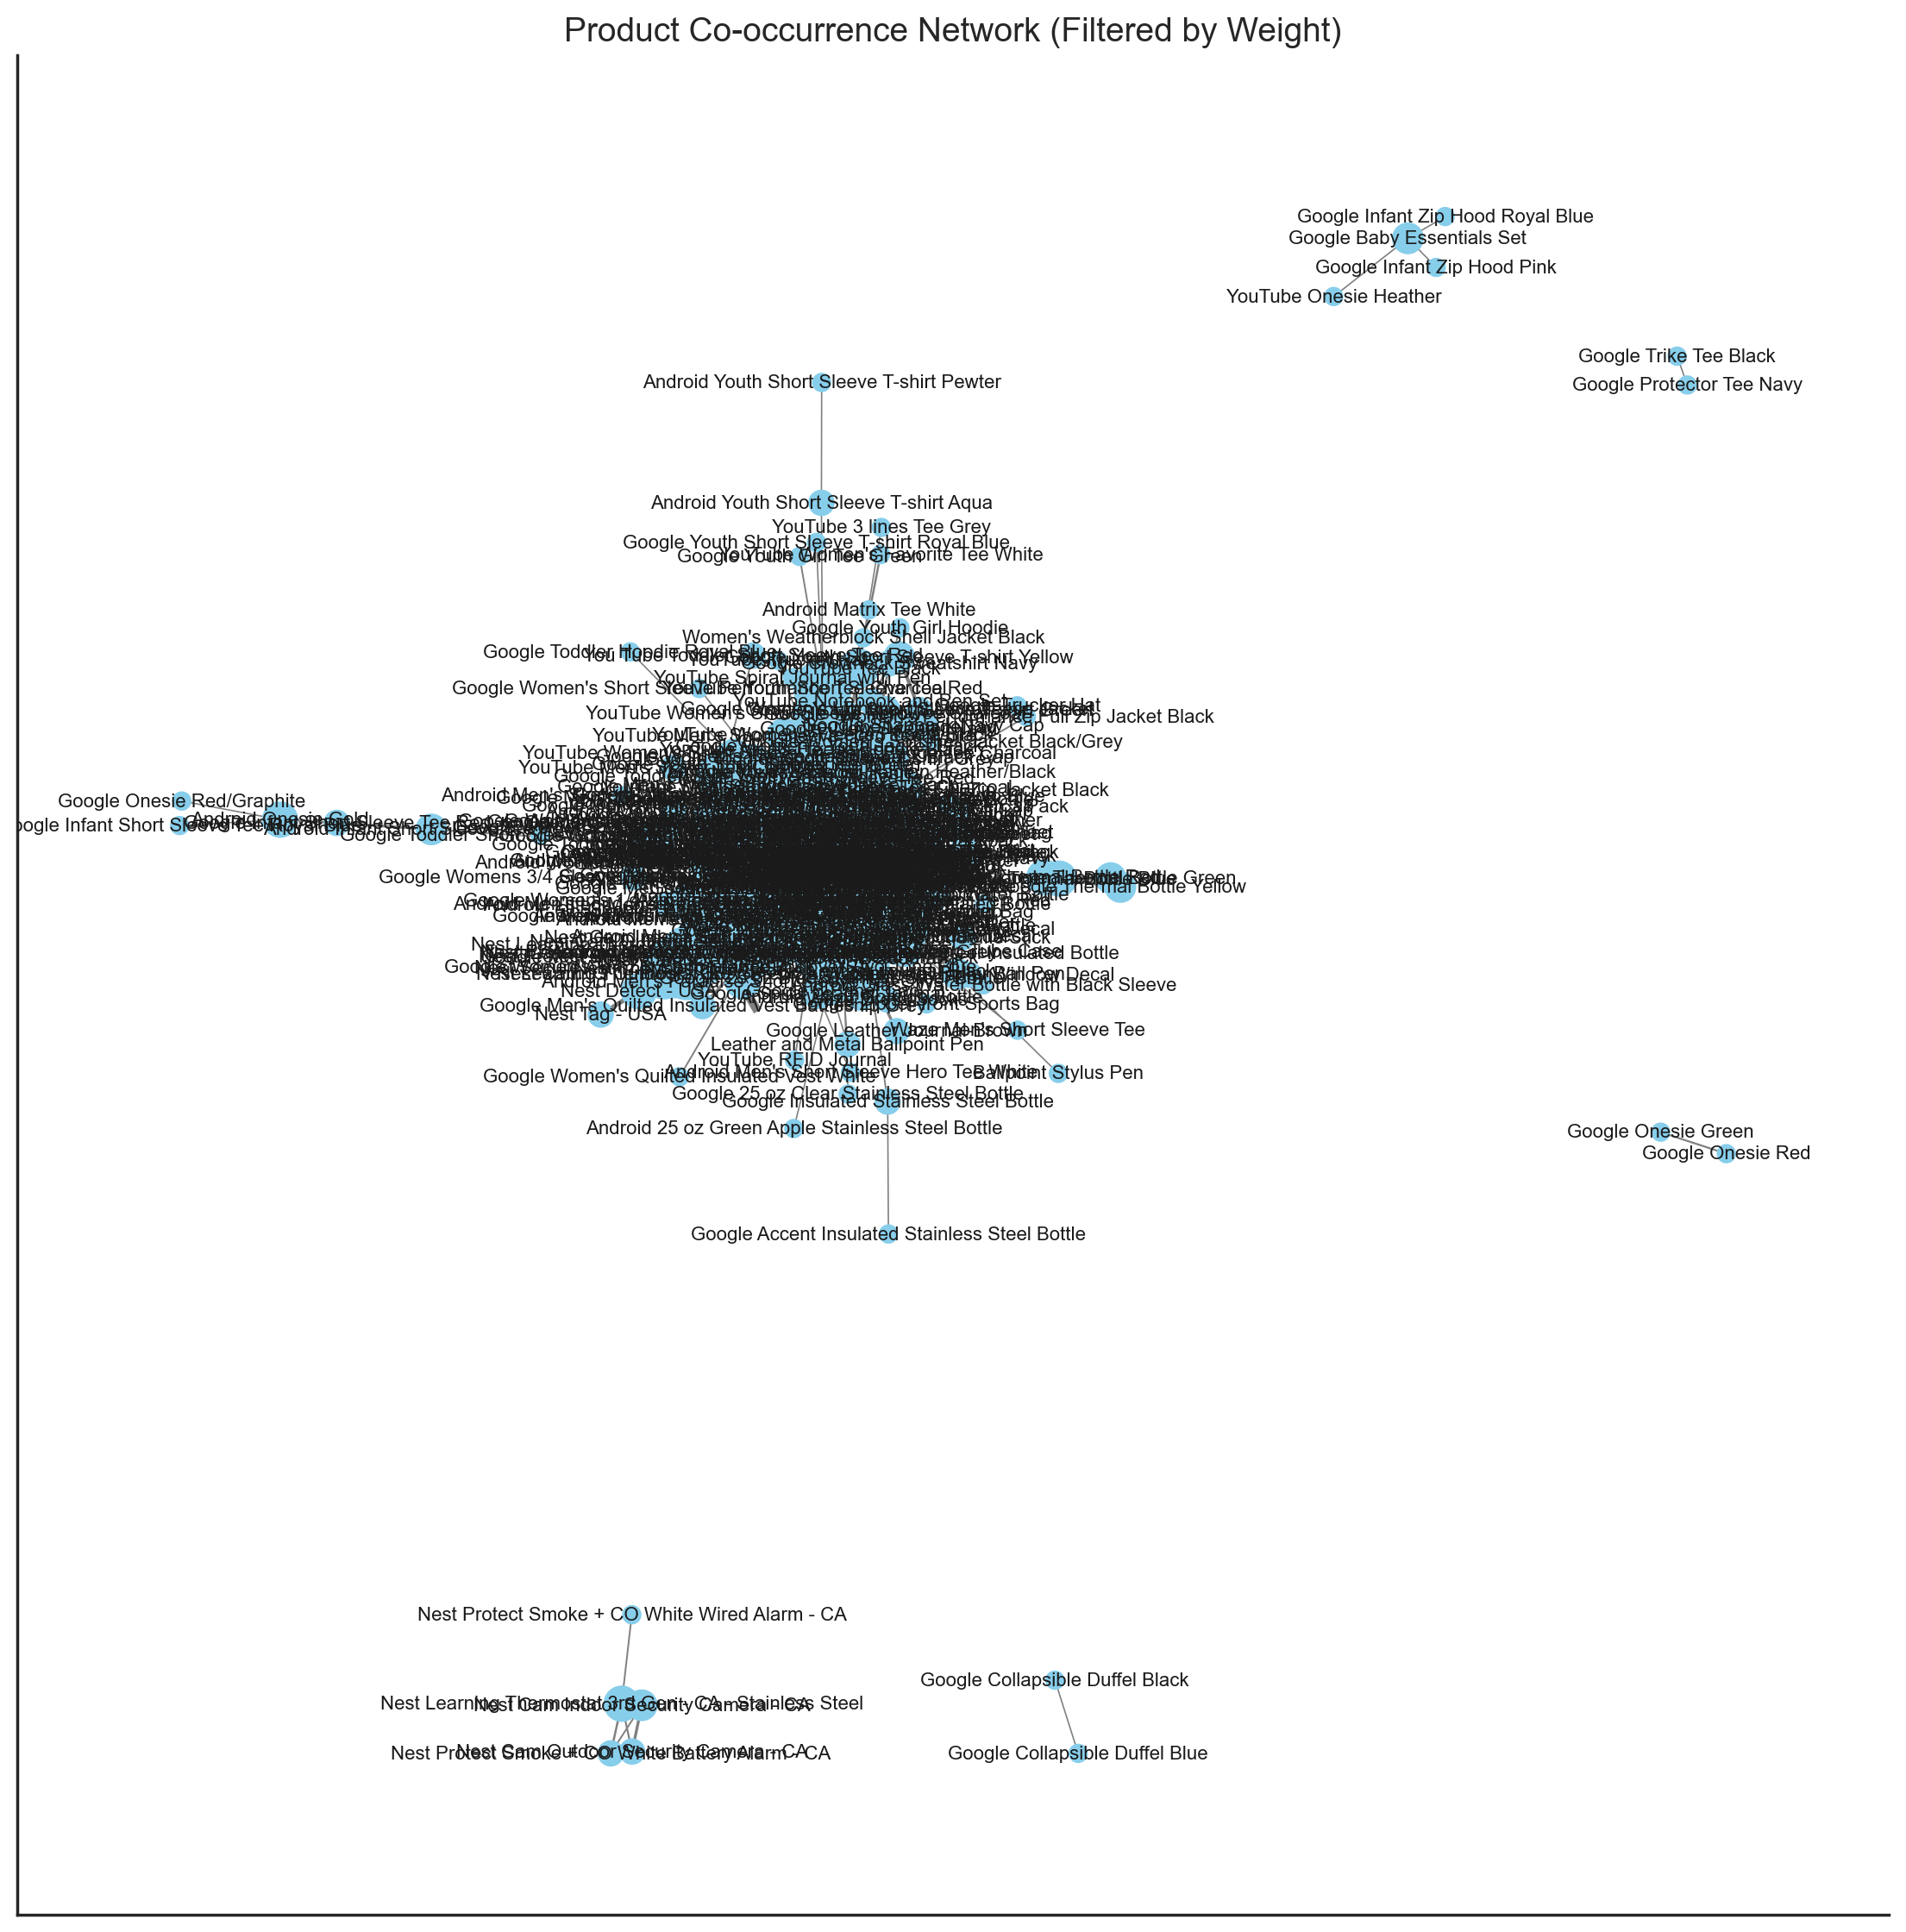

In [36]:

# Create graph from the product-product matrix
G = nx.from_pandas_adjacency(product_matrix)

# Remove self-loops
G.remove_edges_from(nx.selfloop_edges(G))

# Set a threshold for the edge weight
weight_threshold = 5

# Filter edges by weight
edges = [(u, v, d) for u, v, d in G.edges(data=True) if d['weight'] > weight_threshold]
H = nx.Graph()
H.add_edges_from(edges)

# Remove any remaining isolated nodes in H
isolated_nodes_h = list(nx.isolates(H))
H.remove_nodes_from(isolated_nodes_h)

# Plot the graph
plt.figure(figsize=(14, 14))
pos = nx.spring_layout(H, k=0.15)  # positions for all nodes

# Draw nodes with size proportional to their degree
node_size = [v * 50 for v in dict(H.degree()).values()]
nx.draw_networkx_nodes(H, pos, node_size=node_size, node_color='skyblue')

# Draw edges with width proportional to their weight
edge_width = [d['weight']*0.1 for (u, v, d) in H.edges(data=True)]
nx.draw_networkx_edges(H, pos, width=edge_width, edge_color='gray')

# Draw labels
nx.draw_networkx_labels(H, pos, font_size=8)

plt.title("Product Co-occurrence Network (Filtered by Weight)")
plt.show()


In [42]:
# Filter edges by weight and create a DataFrame
edges = [(u, v, d['weight']) for u, v, d in G.edges(data=True) if d['weight'] > weight_threshold]
df_edges = pd.DataFrame(edges, columns=['Product_A', 'Product_B', 'Interaction'])

df_edges['Remove'] = df_edges.apply(lambda x: 'Y' if x['Product_A'] == x['Product_B'] else 'N', axis = 1)


In [44]:
df_edges[df_edges['Remove'] == 'N'].sort_values('Interaction', ascending=False)

,Product_A,Product_B,Interaction,Remove
2360,Nest Cam Indoor Security Camera - USA,Nest Cam Outdoor Security Camera - USA,693,N
2373,Nest Cam Outdoor Security Camera - USA,Nest Learning Thermostat 3rd Gen-USA - Stainle...,301,N
2362,Nest Cam Indoor Security Camera - USA,Nest Learning Thermostat 3rd Gen-USA - Stainle...,228,N
2393,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest Protect Smoke + CO White Battery Alarm-USA,226,N
2375,Nest Cam Outdoor Security Camera - USA,Nest Protect Smoke + CO White Battery Alarm-USA,192,N
...,...,...,...,...
769,Color Changing Grip Pen,Google Doodle Decal,6,N
766,Color Changing Grip Pen,Gel Roller Pen,6,N
1959,Google Men's Watershed Full Zip Hoodie Grey,Men's Weatherblock Shell Jacket Black,6,N
765,Color Changing Grip Pen,Galaxy Screen Cleaning Cloth,6,N
